In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

""""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
"""

'"\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "Helvetica"\n})\n'

In [2]:
torch.manual_seed(42)

In [5]:
num_examples = 1024
data_train = torch.zeros((num_examples, 2), dtype=torch.float32)
data_train[:, 0] = 2 * torch.pi * torch.randn(num_examples)
data_train[:, 1] = torch.sin(data_train[:, 0])
# training data labels for each example, won't be used in GAN as it is an unsupervised learning,
# used for creating the pytorch data loader
data_train_labels = torch.zeros(num_examples)
data_train_set = [(data_train[i], data_train_labels[i]) for i in range(num_examples)]

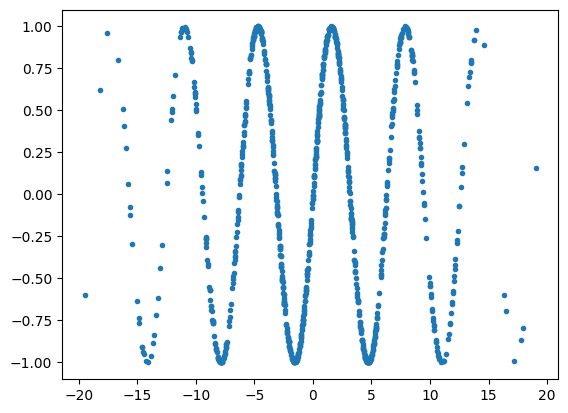

In [4]:
plt.plot(data_train[:, 0], data_train[:, 1], ".")

In [19]:
# pytorch data loader
batch_size = 32
data_train_loader = torch.utils.data.DataLoader(data_train_set, batch_size=batch_size, shuffle=True)

In [11]:
# the dicriminator network,receives two dimensional input either from real data or the generated 
# sample, with a one dimensional output, representing which distribution the input belonged to.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [16]:
# the generator network, receives a 2d point from the latent space, 
# and outputs a 2d point, which should resemble the real data ditribution 
# from training dataset.
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.model(x)

In [30]:
dis = Discriminator()
gen = Generator()
dis_loss_func = nn.BCELoss()
gen_loss_func = nn.BCELoss()

In [31]:
lr = 0.001
num_epochs = 500

In [32]:
dis_optim = torch.optim.Adam(dis.parameters(), lr=lr)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr)

In [36]:
for e in range(num_epochs):
    for b, (real_samples, _) in enumerate(data_train_loader):
        # prepare data for training the discriminator
        real_samples_labels  = torch.ones((batch_size, 1))  # labels for real samples from training data: 1
        latent_samples       = torch.randn((batch_size, 2)) # randomly drawn samples
        gen_samples          = gen(latent_samples)          # generated samples from the generator network
        gen_samples_labels   = torch.zeros((batch_size, 1)) # generated samples labels: 0
        real_and_gen_samples = torch.cat((real_samples, gen_samples))
        real_and_gen_labels  = torch.cat((real_samples_labels, gen_samples_labels))
        
        # training discriminator
        dis.zero_grad()
        dis_output = dis(real_and_gen_samples)
        dis_loss = dis_loss_func(dis_output, real_and_gen_labels)
        dis_loss.backward()
        dis_optim.step()
        
        # new random data from latent space for training the generator
        latent_samples = torch.randn((batch_size, 2))
        
        # training the generator
        gen.zero_grad()
        gen_output = gen(latent_samples)
        dis_output_from_gen = dis(gen_output) # output of discriminator from generated samples
        gen_loss = gen_loss_func(dis_output_from_gen, real_samples_labels)
        gen_loss.backward()
        gen_optim.step()
        
        # print loss every 10 epoch for the final example in a batch
        if (e % 10 == 0) and (b == batch_size - 1):
            print(f"Epoch: {e}: Generator Loss: {gen_loss}, Discriminator Loss: {dis_loss}")

Epoch: 0: Generator Loss: 1.3132091760635376, Discriminator Loss: 0.3692780137062073
Epoch: 10: Generator Loss: 1.2473597526550293, Discriminator Loss: 0.3557484447956085
Epoch: 20: Generator Loss: 1.220632791519165, Discriminator Loss: 0.47811976075172424
Epoch: 30: Generator Loss: 1.6177812814712524, Discriminator Loss: 0.46523192524909973


KeyboardInterrupt: 

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = gen(latent_space_samples)

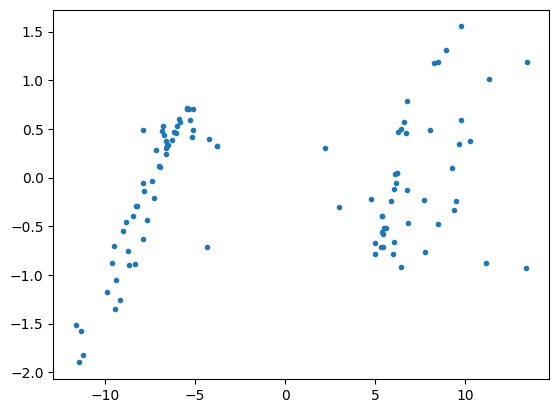

In [35]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [38]:
import torchvision
import torchvision.transforms as transforms

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
# ToTensor transoform ranges from 0 to 1, 0 for black, most of the image background in MNIST 
# is black, so the majority is 0, the Normalize transforms the pixel values to be in range -1 to 1
# by subtracting 0.5 from values and dividing by 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [42]:
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 13592528.39it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 42623396.84it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 12844526.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4820477.93it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [43]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

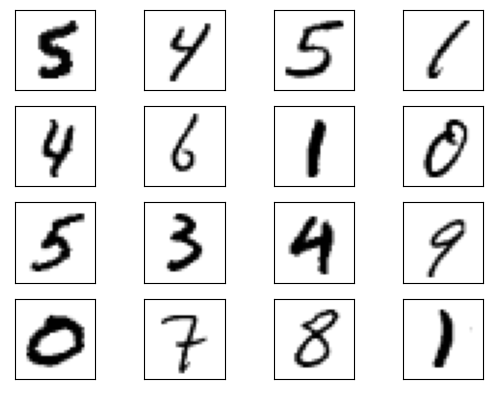

In [44]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784) # (32, 1, 28, 28) -> (32, 784)
        output = self.model(x)
        return output

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [47]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [48]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [49]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5279402732849121
Epoch: 0 Loss G.: 0.5299214124679565
Epoch: 1 Loss D.: 0.04890106990933418
Epoch: 1 Loss G.: 5.186410427093506
Epoch: 2 Loss D.: 0.00563739612698555
Epoch: 2 Loss G.: 6.116168975830078
Epoch: 3 Loss D.: 0.17529916763305664
Epoch: 3 Loss G.: 4.509341716766357
Epoch: 4 Loss D.: 0.08617910742759705
Epoch: 4 Loss G.: 4.487814426422119
Epoch: 5 Loss D.: 0.016322912648320198
Epoch: 5 Loss G.: 5.231188774108887
Epoch: 6 Loss D.: 2.180479441449279e-07
Epoch: 6 Loss G.: 32.34009552001953
Epoch: 7 Loss D.: 2.0489110852395243e-08
Epoch: 7 Loss G.: 79.8346176147461
Epoch: 8 Loss D.: 1.250691754742636e-20
Epoch: 8 Loss G.: 60.13822555541992
Epoch: 9 Loss D.: 3.518537639766799e-18
Epoch: 9 Loss G.: 58.375789642333984


KeyboardInterrupt: 

In [50]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

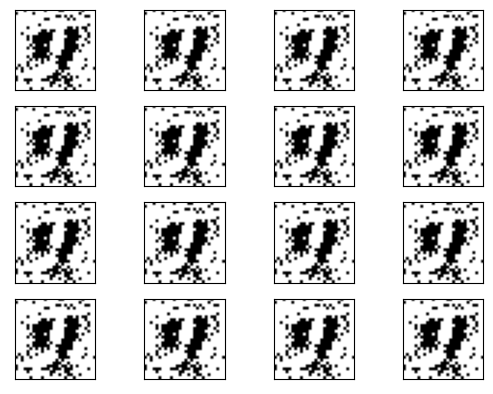

In [51]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])